![EU Banner](images/eu_banner.png)

# **4) Monte Carlo Calibration Example**
***
This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).</br>
This notebook demonstrates a simple Monte Carlo-based calibration for LISFLOOD. </br>
It generates *N* random parameter sets within defined bounds and runs the model for each set.</br>
In the official GloFAS and EFAS versions, the calibration is of course not done with a simple random sampling, but a genetic algorithm called DEAP is used (see [Fortin et al., 2012](https://www.jmlr.org/papers/volume13/fortin12a/fortin12a.pdf)).</br>
* Technical details of the calibration tool itself can be found [here](https://github.com/ec-jrc/lisflood-calibration).
* EFAS-specific details, such as on parameters, skill and calibrated basins, you can get [here](https://confluence.ecmwf.int/display/CEMS/EFAS+v5.0+-+Calibration+Methodology+and+Data).
* The GloFAS counterpart you find [here](https://confluence.ecmwf.int/display/CEMS/GloFAS+v4+calibration+methodology+and+parameters).

***

## Parameters and their bounds
In the following we will quickly provide an overview about LISFLOOD's main calibration parameter.</br>
Main calibration parameters here refers to the fact that those are (some) of the ones used in the official GloFAS and EFAS calibration strategies.</br>
However, as users potentially have noticed already throughout the work with the settings files, there are plenty of other parameters that could be changed. <br>
In a snow-affected catchment like the Aisen, people might want more control than just relying on the degree-day factor (*SnowMeltCoef*) and for example also adjust the melt temperature itself, which is not touched in the official GloFAS and EFAS calibrations. 
| ParameterName         | MinValue | MaxValue | Default Value | GloFAS Calib. Aisen |
|-----------------------|---------:|---------:|-------------:|-------------:|
| UpperZoneTimeConstant  | 0.01     | 40       | 10           | 9.0402       |
| LowerZoneTimeConstant  | 40       | 730      | 100          | 40           |
| GwPercValue            | 0.01     | 2        | 0.8          | 0.878763     |
| LZThreshold            | 0        | 30       | 10           | 5.65075      |
| b_Xinanjiang           | 0.01     | 5        | 0.5          | 3.09004      |
| PowerPrefFlow          | 0.5      | 8        | 4            | 1.51084      |
| SnowMeltCoef           | 2.5      | 6.5      | 4            | 5.10491      |    
| CalChanMan1            | 0.5      | 2        | 1            | 4.49689      |
| CalChanMan3            | 0.5      | 5        | 3            | 1            |
| GwLoss                 | 0        | 0.5      | 0            | 0.0866118    |
| TransSub               | 0        | 0.12     | 0            | 0.000135783  |  

As always, let us quickly load the necessary libraries before we start.

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import subprocess
import xml.etree.ElementTree as ET
import time
import matplotlib.pyplot as plt


Remember, all the parameters and settings are done in xml format, to adapt the settings files we will therefore create 3 helper functions:
* `set_textvar`: to change whatever parameter in a specific xml file
* `generate_random_params`: to generate *N* random samples for a parameter
* `run_lisflood`: obviously to run LISFLOOD

In [9]:
# Universally applicable Lisflood TSS Read Function
def read_lisflood_tss(
    out_dir: Path,
    varname: str,
    run_name: str,
    start_date: str,
    n_gauges: int,
    skiprows: int,
    freq: str = "D"
) -> pd.DataFrame:
    """
    Robust reader for LISFLOOD .tss files with varname+runname convention.
    Handles small float values correctly.
    """
    # run_name = out_dir.name
    tss_file = out_dir / f"{varname}{run_name}.tss"

    if not tss_file.exists():
        print(f"⚠️ Missing LISFLOOD file → filled with NaNs: {tss_file}")
        return pd.DataFrame(
            columns=[f"gauge_{i+1}" for i in range(n_gauges)]
        )

    # Read the file using whitespace delimiter for robustness
    df = pd.read_csv(
        tss_file,
        skiprows=skiprows,
        delim_whitespace=True,
        header=None,
        usecols=range(n_gauges + 1),  # only keep index + gauges
        dtype={i: float for i in range(1, n_gauges + 1)}  # gauge columns as float
    )

    # Only keep the first n_gauges + 1 columns (date/index + gauges)
    df = df.iloc[:, : n_gauges + 1]

    # Convert gauge columns to float safely
    for i in range(1, n_gauges + 1):
        df[i] = df[i].astype(float)

    # Set column names
    df.columns = ["date"] + [f"gauge_{i+1}" for i in range(n_gauges)]

    # Create date index
    df["date"] = pd.date_range(start=start_date, periods=len(df), freq=freq)
    return df.set_index("date")

def set_textvar(root, name, new_value, must_exist=True):
    """
    Modify the 'value' attribute of a <textvar> element in a LISFLOOD settings file.

    Parameters
    ----------
    root : xml.etree.ElementTree.Element
        Root element of the parsed XML tree (typically <lfsettings>).
    name : str
        Value of the 'name' attribute of the <textvar> to modify.
    new_value : str or float or int
        New value to assign to the 'value' attribute.
    must_exist : bool, optional
        If True (default), raise an error if the parameter is not found.
        If False, silently do nothing if the parameter does not exist.

    Returns
    -------
    bool
        True if the parameter was found and modified, False otherwise.
    """
    for tv in root.iter("textvar"):
        if tv.attrib.get("name") == name:
            tv.attrib["value"] = str(new_value)
            return True

    if must_exist:
        raise KeyError(f"textvar '{name}' not found in settings file")

    return False


def generate_random_params(param_bounds, n_samples, seed=None):
    """
    Generate random parameter sets within defined bounds.

    Parameters
    ----------
    param_bounds : dict
        Dictionary with parameter names as keys and (min, max) tuples as values.
    n_samples : int
        Number of parameter sets to generate.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    list of dict
        List of parameter dictionaries.
    """
    if seed is not None:
        np.random.seed(seed)

    param_sets = []
    for i in range(n_samples):
        params = {}
        for name, (min_val, max_val) in param_bounds.items():
            params[name] = np.random.uniform(min_val, max_val)
        param_sets.append(params)

    return param_sets


def run_lisflood(settings_file):
    """
    Run LISFLOOD model using command line.

    Parameters
    ----------
    settings_file : str
        Path to the settings XML file.
        
    Returns
    -------
    int
        Return code (0 = success).
    """
    cmd = [
        "lisflood",
        settings_file,
        # "--stepstart", step_start,
        # "--stepend", step_end,
        # "--outputdir", str(output_dir)
    ]
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    return result.returncode

def fun_kge(obs, sim):
    # Align on overlapping dates
    obs_aligned, sim_aligned = obs.align(sim, join='inner', axis=0)
    
    # Drop any NaNs
    mask = obs_aligned.notna() & sim_aligned.notna()
    obs_aligned = obs_aligned[mask]
    sim_aligned = sim_aligned[mask]
    
    r = np.corrcoef(obs_aligned, sim_aligned)[0,1]
    alpha = np.std(sim_aligned)/np.std(obs_aligned)
    beta = np.mean(sim_aligned)/np.mean(obs_aligned)
    
    return 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)

***
## 4a) General Configuration

We actually prepared already 2 calibration settings files in the `\settings` folder:
1. `Settings_PreRun_Calib`
2. `Settings_Run_Calib`

The two settings files should in theory be already prepared to include a short calibration period (for demonstration purposes to improve run times) and additionally they should only print discharge in order to quickly demonstrate how discharge performs with respect to the calibrated GloFAS long-term run. </br>
The simulation period is set just 5 years including a 3 years warm-up (1975 - 1979).  


In [10]:
# ============================================================
# CONFIGURATION - Change these values as needed
# ============================================================

# Number of Monte Carlo samples
N_SAMPLES = 10  # Can be changed to any number (e.g., 100, 1000)

# Paths
BASE_DIR = Path("..")
IN_DIR = BASE_DIR / "settings"
OUT_DIR = BASE_DIR / "out" / "calib_mc"
SETTINGS_FILE_PRE = "Settings_PreRun_Calib.xml"
SETTINGS_FILE = "Settings_Run_Calib.xml"

# Create output directory
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Simulation period (for this example we recomend to keep it short)
STEP_START = "01/02/1996 00:00"
STEP_END = "01/01/2000 00:00"

If you want to change the provided LISFLOOD settings files in order to change the simulation period for example, we here provide a small example how easily it can be done with our helper functions.

In [11]:
# Define setup
setup_lf = {
    "StepStart": f"{STEP_START}",
    "StepEnd": f"{STEP_END}",
    "PathOut": f"{OUT_DIR}",
    "PathInit": "$(PathRoot)/initial/calib_mc",
}

# Copy and modify settings file (do this ONCE before the loop)
settings_path = IN_DIR / SETTINGS_FILE
settings_pre_path = IN_DIR / SETTINGS_FILE_PRE
settings_tree = ET.parse(settings_path)
settings_pre_tree = ET.parse(settings_pre_path)
root = settings_tree.getroot()
root_pre = settings_pre_tree.getroot()

# Loop through parameters and apply changes
for param, value in setup_lf.items():
    changed = set_textvar(root, param, value, must_exist=True)
    set_textvar(root_pre, param, value, must_exist=True)
    if not changed:
        print(f"⚠ Parameter '{param}' not found — no change applied")

# Write the modified files ONCE after all changes
settings_tree.write(IN_DIR / SETTINGS_FILE)
settings_pre_tree.write(IN_DIR / SETTINGS_FILE_PRE)



---
## 4b) Actual Calibration
In the following we will first define our calibration parameters and according ranges, before we apply the random sampling followed by the calibration run for the already defined *N* (sample size). 
### Define Parameter Bounds
First we define the parameters and their bounds

In [12]:
# Parameter bounds for Monte Carlo sampling
# (name, min_value, max_value)
PARAM_BOUNDS = {
    "UpperZoneTimeConstant": (0.01, 40),
    "LowerZoneTimeConstant": (40, 730),
    "GwPercValue": (0.01, 2),
    "LZThreshold": (0, 30),
    "b_Xinanjiang": (0.01, 5),
    "PowerPrefFlow": (0.5, 8),
    "SnowMeltCoef": (2.5, 6.5),
    "CalChanMan1": (0.5, 2),
    "CalChanMan3": (0.5, 5),
    "GwLoss": (0, 0.5),
    "TransSub": (0, 0.12)
}

print(f"Number of parameters: {len(PARAM_BOUNDS)}")
print(f"Monte Carlo samples: {N_SAMPLES}")
print(f"\nParameter bounds:")
for name, (min_val, max_val) in PARAM_BOUNDS.items():
    print(f"  {name}: [{min_val}, {max_val}]")

Number of parameters: 11
Monte Carlo samples: 10

Parameter bounds:
  UpperZoneTimeConstant: [0.01, 40]
  LowerZoneTimeConstant: [40, 730]
  GwPercValue: [0.01, 2]
  LZThreshold: [0, 30]
  b_Xinanjiang: [0.01, 5]
  PowerPrefFlow: [0.5, 8]
  SnowMeltCoef: [2.5, 6.5]
  CalChanMan1: [0.5, 2]
  CalChanMan3: [0.5, 5]
  GwLoss: [0, 0.5]
  TransSub: [0, 0.12]


### Monte Carlo Sampling
Now, we use the helper function to generate random parameter sets that are used for the calibration.

In [13]:
# Generate random parameter sets
np.random.seed(42)  # For reproducibility
param_sets = generate_random_params(PARAM_BOUNDS, N_SAMPLES, seed=42)

print(f"Generated {len(param_sets)} random parameter sets")
print("\nFirst 3 parameter sets:")
for i, params in enumerate(param_sets[:3]):
    print(f"\nSet {i+1}:")
    for name, value in params.items():
        print(f"  {name}: {value:.4f}")

Generated 10 random parameter sets

First 3 parameter sets:

Set 1:
  UpperZoneTimeConstant: 14.9879
  LowerZoneTimeConstant: 695.9929
  GwPercValue: 1.4667
  LZThreshold: 17.9598
  b_Xinanjiang: 0.7885
  PowerPrefFlow: 1.6700
  SnowMeltCoef: 2.7323
  CalChanMan1: 1.7993
  CalChanMan3: 3.2050
  GwLoss: 0.3540
  TransSub: 0.0025

Set 2:
  UpperZoneTimeConstant: 38.7967
  LowerZoneTimeConstant: 614.3854
  GwPercValue: 0.4326
  LZThreshold: 5.4547
  b_Xinanjiang: 0.9252
  PowerPrefFlow: 2.7818
  SnowMeltCoef: 4.5990
  CalChanMan1: 1.1479
  CalChanMan3: 1.8105
  GwLoss: 0.3059
  TransSub: 0.0167

Set 3:
  UpperZoneTimeConstant: 11.6929
  LowerZoneTimeConstant: 292.7897
  GwPercValue: 0.9176
  LZThreshold: 23.5553
  b_Xinanjiang: 1.0064
  PowerPrefFlow: 4.3568
  SnowMeltCoef: 4.8697
  CalChanMan1: 0.5697
  CalChanMan3: 3.2340
  GwLoss: 0.0853
  TransSub: 0.0078


In [14]:
# Run Monte Carlo simulations
results = []

print("=" * 60)
print(f"Starting Monte Carlo Calibration ({N_SAMPLES} runs)")
print("=" * 60)

start_time = time.time()
# Loop over parameter sets
for i, params in enumerate(param_sets):
    run_id = i + 1
    print(f"\n--- Run {run_id}/{N_SAMPLES} ---")
    
    # Create unique output directory for this run
    run_out_dir = OUT_DIR / f"run_{run_id:04d}"
    run_out_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy and modify settings file
    settings_path = IN_DIR / SETTINGS_FILE
    settings_pre_path = IN_DIR / SETTINGS_FILE_PRE
    settings_tree = ET.parse(settings_path)
    settings_pre_tree = ET.parse(settings_pre_path)
    root = settings_tree.getroot()
    root_pre = settings_pre_tree.getroot()

    # Set output path
    set_textvar(root, "PathOut", str(run_out_dir), must_exist=False)
    set_textvar(root_pre, "PathOut", str(run_out_dir), must_exist=False)
   
    # Make sure Init Folder is correct -> in this case init files (lzavin) are in the output fodler to make it simple
    # set_textvar(root, "PathInit", "$(PathRoot)/initial/calib_mc", must_exist=False)
    # set_textvar(root_pre, "PathInit", "$(PathRoot)/initial/calib_mc", must_exist=False)
    set_textvar(root, "PathInit", str(run_out_dir), must_exist=False)
    set_textvar(root_pre, "PathInit", str(run_out_dir), must_exist=False)

    # Set calibration parameters
    for param, value in params.items():
        set_textvar(root, param, value, must_exist=False)
        set_textvar(root_pre, param, value, must_exist=False)
    
    # Write modified settings file to calib folder and run from there
    run_settings_file = run_out_dir / "settings_mc.xml"
    pre_run_settings_file = run_out_dir / "settings_pre_mc.xml"
    settings_tree.write(run_settings_file)
    settings_pre_tree.write(pre_run_settings_file)

    # Run LISFLOOD (both Prerun & Actual Run)
    print(f"  Parameters: ", end="")
    print(", ".join([f"{k}={v:.2f}" for k, v in list(params.items())[:3]]) + "...")
    
    # Pre-Run
    run_lisflood(str(pre_run_settings_file))
    # Actual Run
    return_code = run_lisflood(str(run_settings_file))
    
    if return_code == 0:
        print(f"  ✓ Run completed successfully")
        results.append({
            "run_id": run_id,
            "params": params,
            "return_code": return_code,
            "output_dir": run_out_dir
        })
    else:
        print(f"  ✗ Run failed with code {return_code}")
        results.append({
            "run_id": run_id,
            "params": params,
            "return_code": return_code,
            "output_dir": run_out_dir
        })

elapsed_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"Monte Carlo Calibration Complete")
print(f"Total time: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
print(f"Successful runs: {sum(1 for r in results if r['return_code'] == 0)}/{N_SAMPLES}")
print("=" * 60)

Starting Monte Carlo Calibration (10 runs)

--- Run 1/10 ---
  Parameters: UpperZoneTimeConstant=14.99, LowerZoneTimeConstant=695.99, GwPercValue=1.47...
  ✓ Run completed successfully

--- Run 2/10 ---
  Parameters: UpperZoneTimeConstant=38.80, LowerZoneTimeConstant=614.39, GwPercValue=0.43...
  ✓ Run completed successfully

--- Run 3/10 ---
  Parameters: UpperZoneTimeConstant=11.69, LowerZoneTimeConstant=292.79, GwPercValue=0.92...
  ✓ Run completed successfully

--- Run 4/10 ---
  Parameters: UpperZoneTimeConstant=37.96, LowerZoneTimeConstant=706.29, GwPercValue=1.62...
  ✓ Run completed successfully

--- Run 5/10 ---
  Parameters: UpperZoneTimeConstant=10.36, LowerZoneTimeConstant=497.14, GwPercValue=0.63...
  ✓ Run completed successfully

--- Run 6/10 ---
  Parameters: UpperZoneTimeConstant=36.88, LowerZoneTimeConstant=101.06, GwPercValue=0.40...
  ✓ Run completed successfully

--- Run 7/10 ---
  Parameters: UpperZoneTimeConstant=5.65, LowerZoneTimeConstant=593.52, GwPercValue=0.1


---
## 4c) Compare Calibration Results
We will now load the discharge time series and compare them against each other and the observations to see how the runs differ.

In [15]:
# Read Observed Q Data
OBS_FILE = BASE_DIR / "station"/ "observations.csv" 
qobs = pd.read_csv(OBS_FILE,skiprows=1, names=["date", "qobs"], parse_dates=["date"],dayfirst=True)
qobs = qobs.set_index("date")
# get rid of the timestamp
qobs.index = qobs.index.normalize()

# Read Simulated Q Data
run_name = "long_term_run"
DIS_FILES = list(OUT_DIR.glob(f"*/dis{run_name}.tss"))
DIS_FOLDS = list(OUT_DIR.glob(f"run_*"))

with open(DIS_FILES[0]) as f:
    lines = f.readlines()

# Extract number of gauges
n_gauges = int(lines[1].strip()) - 1
skiprows = 3 + n_gauges

# Read Sim (all Vars)
var = "dis"

qsim_cal = []

# Actual Read of files
for fold in DIS_FOLDS:
        qsim = read_lisflood_tss(
            fold, var, run_name, STEP_START, n_gauges, skiprows
        )
        qsim_cal.append(qsim)

# Convert to DataFrame
run_names = [f.parent.name for f in DIS_FILES]  # e.g., "run_0001", "run_0002", ...
qsim_cal = pd.concat(qsim_cal, axis=1)
qsim_cal.columns = run_names

# Load also long-term run simulation from before
outfold = Path("/home/schafti/Documents/01_Hydrology/01_Lisflood/00_SourceCode/01_Playground/01_Test_Usecase/create_submodel_7859/7859_testing/out/long_term_run/")
STEP_START_ORIG = "01/02/1975 00:00" 
qsim_original = read_lisflood_tss(
            outfold, var, run_name, STEP_START_ORIG, n_gauges, skiprows
        )

We should also  quickly align the dataframes!

In [16]:
# Align everything
# common_index = qobs.index.intersection(qsim_cal.index)
# qobs_al = qobs.loc[common_index]
# qsim_al = qsim_cal.loc[common_index]

qsim_cal, qobs = qsim_cal.align(qobs, join='inner', axis=0)
qsim_original, _ = qsim_original.align(qobs, join='inner', axis=0)

### Discharge Results

KGE Results (sorted by KGE):
       run       KGE
GloFAS_Cal  0.713969
  run_0003  0.034059
  run_0009  0.023951
  run_0002  0.023254
  run_0010  0.017274
  run_0001  0.004435
  run_0008 -0.061810
  run_0006 -0.069593
  run_0005 -0.084286
  run_0007 -0.098712
  run_0004 -0.123779

Best run: GloFAS_Cal with KGE = 0.714
Mean KGE: 0.034


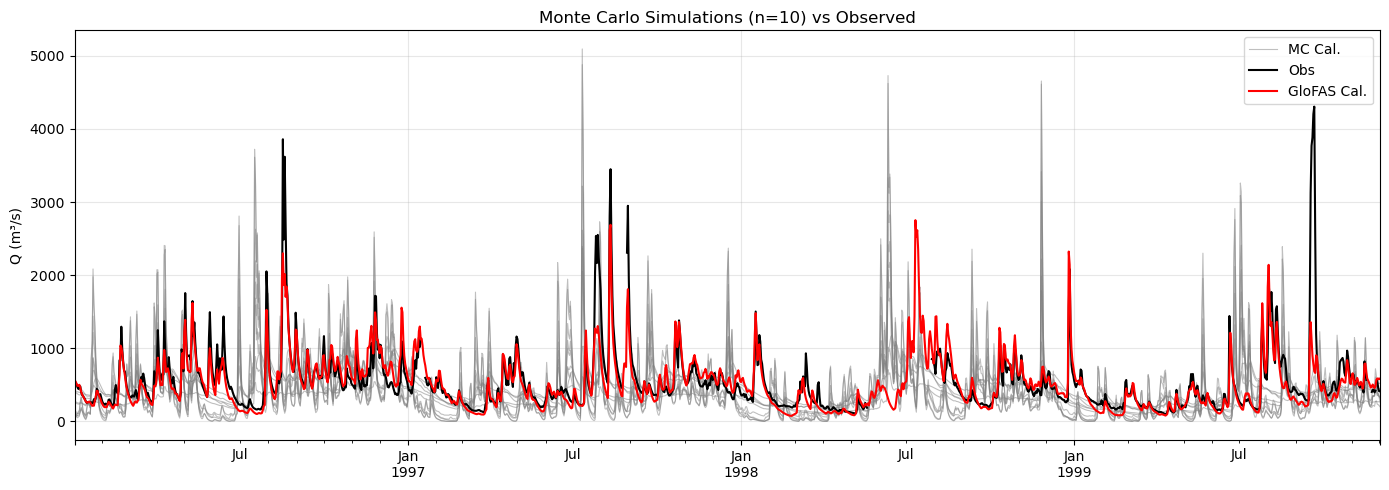

In [17]:
# --- Plot all simulations in grey ---
fig, ax = plt.subplots(figsize=(14, 5))

# Plot each simulation in grey
for col in qsim_cal.columns:
    qsim_cal[col].plot(ax=ax, color="grey", alpha=0.5, lw=0.8)

# Plot observed data in black
qobs.plot(ax=ax, color="black", lw=1.5, label="Observed")

# Plot calibrated GloFAS long term run from before
qsim_original.plot(ax=ax, color="r", lw=1.5, label="GloFAS Cal.")
 
ax.set_ylabel("Q (m³/s)")
ax.set_xlabel("")
ax.set_title(f"Monte Carlo Simulations (n={len(qsim_cal.columns)}) vs Observed")
ax.grid(True, alpha=0.3)
mc_handle   = ax.lines[0]                      # first MC line
obs_handle  = ax.lines[-2]  # observed
orig_handle = ax.lines[-1]                     # last line
ax.legend(
    [mc_handle, obs_handle, orig_handle],
    ["MC Cal.", "Obs", "GloFAS Cal."]
)
plt.tight_layout()


# Calculate KGE for each run
kge_results = []
for col in qsim_cal.columns:
    kge_val= fun_kge(qobs.squeeze(), qsim_cal[col].squeeze())
    kge_results.append({
        "run": col,
        "KGE": kge_val,
    })
kge_val_glofas = fun_kge(qobs.squeeze(), qsim_original.squeeze())
kge_results.append({
    "run": "GloFAS_Cal",
    "KGE": kge_val_glofas,
})
# Create DataFrame
kge_df = pd.DataFrame(kge_results)
kge_df = kge_df.sort_values("KGE", ascending=False).reset_index(drop=True)

print("KGE Results (sorted by KGE):")
print(kge_df.to_string(index=False))

print(f"\nBest run: {kge_df.iloc[0]['run']} with KGE = {kge_df.iloc[0]['KGE']:.3f}")
print(f"Mean KGE: {kge_df['KGE'].mean():.3f}")


### Parameterizations Check

We see that we did not beat the original GloFAS calibration run with our MC sampling approach, albeit some of the runs are pretty close.</br>
However, let us inspect the worst run, to get an idea what happens there.

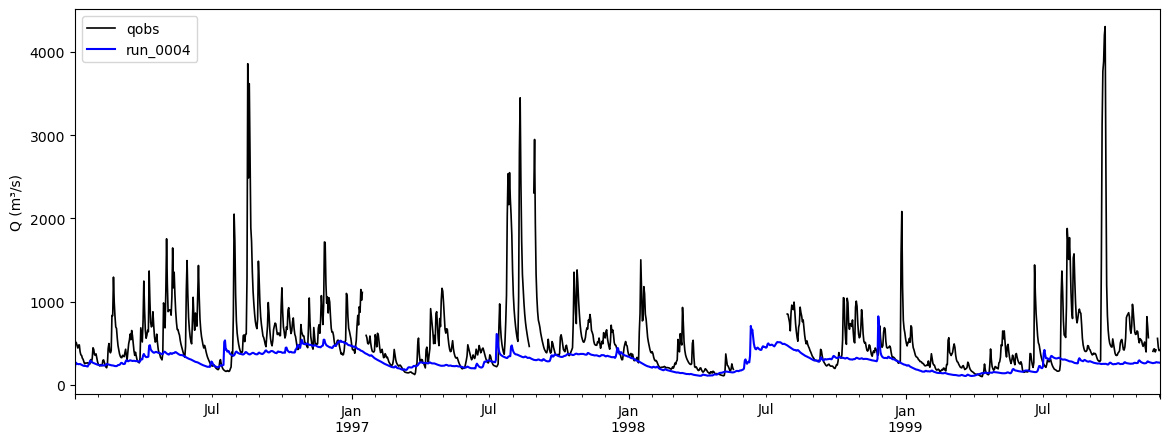

In [18]:
# Extract the worst run, its index is of course the run number -1 
sim = "run_0004"
sim_ind = 3
test_params = param_sets[sim_ind]

fig, ax = plt.subplots(figsize=(14, 5))
qobs.plot(ax=ax, color="black", lw=1.2, label="Observed")
qsim_cal[sim].plot(ax=ax, lw=1.5, c= "blue")
ax.set_ylabel("Q (m³/s)")
ax.set_xlabel("")
ax.legend();

In the beginning of this notebook we provided the original calibrated GloFAS parameter set for the Aisen River, so let us have a look at the parameter differences that could be responsible for the very smoothed behavior of the bad LISFLOOD simulation.

In [21]:
# Calibration parameters (GloFAS Calib. Aisen)
calib_params = {
 'UpperZoneTimeConstant': 9.0402,
 'LowerZoneTimeConstant': 40,
 'GwPercValue': 0.878763,
 'LZThreshold': 5.65075,
 'b_Xinanjiang': 3.09004,
 'PowerPrefFlow': 1.51084,
 'SnowMeltCoef': 5.10491,
 'CalChanMan1': 4.49689,
 'CalChanMan3': 1,
 'GwLoss': 0.0866118,
 'TransSub': 0.000135783
}

Let us check the difference among the parameter sets!

In [22]:
# Iterate and print
for key in test_params.keys():

    test_val = test_params[key]
    glofas_val = calib_params[key]

    abs_diff = test_val - glofas_val
    rel_diff = (abs_diff / glofas_val) * 100 if glofas_val != 0 else float("nan")

    print(f"{key:25s} | "
          f"Test Set: {test_val:10.5f} | "
          f"GloFAS Cal: {glofas_val:10.5f} | "
          f"Diff: {abs_diff:10.5f} | "
          f"%Diff: {rel_diff:8.2f}%")

UpperZoneTimeConstant     | Test Set:   37.95593 | GloFAS Cal:    9.04020 | Diff:   28.91573 | %Diff:   319.86%
LowerZoneTimeConstant     | Test Set:  706.28610 | GloFAS Cal:   40.00000 | Diff:  666.28610 | %Diff:  1665.72%
GwPercValue               | Test Set:    1.61871 | GloFAS Cal:    0.87876 | Diff:    0.73995 | %Diff:    84.20%
LZThreshold               | Test Set:    9.13841 | GloFAS Cal:    5.65075 | Diff:    3.48766 | %Diff:    61.72%
b_Xinanjiang              | Test Set:    0.49738 | GloFAS Cal:    3.09004 | Diff:   -2.59266 | %Diff:   -83.90%
PowerPrefFlow             | Test Set:    5.63175 | GloFAS Cal:    1.51084 | Diff:    4.12091 | %Diff:   272.76%
SnowMeltCoef              | Test Set:    4.26061 | GloFAS Cal:    5.10491 | Diff:   -0.84430 | %Diff:   -16.54%
CalChanMan1               | Test Set:    0.68306 | GloFAS Cal:    4.49689 | Diff:   -3.81383 | %Diff:   -84.81%
CalChanMan3               | Test Set:    2.72830 | GloFAS Cal:    1.00000 | Diff:    1.72830 | %Diff:   

We can immediately spot a couple of significant differences, such as the UZTC, LZTC and PowerPrefFlow parameters that shows notable shifts from the best run.</br>
In fact, the best run LZTC is at the lower edge of the allowed range while the UZTC, LZTC of the bad run is close to the upper limit of both parameters!</br>

However, you could for example check how the parameters of the best MC run look compared to the best run and the worst run to get a better idea.